# LightGBM Regression for Cherry Blossom Bloom Day

This notebook trains a LightGBM regression model to predict cherry blossom bloom day. It mirrors the OLS and SARIMAX notebooks: same data splits, metrics, and plotting style.


## Plan and assumptions

- Use the same numeric predictors as in the OLS and SARIMA notebooks.
- Use years 1921–2015 as the pool for training/validation and perform a sequential 80/20 split to preserve temporal order.
- Reserve 2016–2025 as the test set and report performance on that set.
- Metrics: RMSE, MAE, and WMAPE (sum(|error|) / sum(|actual|)).
- We'll use LightGBM's sklearn API with early stopping on the validation set.


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

sns.set_theme(style='whitegrid')


## 1) Load data

In [43]:
DATA_PATH = '../data/cherry_blossom_data.csv'
df = pd.read_csv(DATA_PATH)
print('Loaded rows:', len(df))
df.head()


Loaded rows: 107


,year,days_dec_ge_45,days_jan_ge_45,days_feb_ge_45,prec_winter,mean_temp_winter,surface_temp_chg,climate_incidents,bloom_day
0,1921,30,24,23,3.41,42.8,-0.05,3,79
1,1922,20,17,19,2.56,39.1,-0.12,2,97
2,1923,18,15,14,3.12,36.4,-0.18,1,99
3,1924,25,22,25,3.68,43.2,-0.09,4,104
4,1925,16,12,14,2.89,36.8,-0.14,2,86


## 2) Prepare features and target

In [44]:
numeric_cols = ['days_dec_ge_45','days_jan_ge_45','days_feb_ge_45','prec_winter',
                'mean_temp_winter','surface_temp_chg','climate_incidents']
for c in numeric_cols + ['bloom_day','year']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows with missing essential values
df = df.dropna(subset=['year','bloom_day'] + numeric_cols).reset_index(drop=True)

FEATURES = numeric_cols
TARGET = 'bloom_day'


## 3) Create train / validation / test splits (sequential)

In [45]:
train_val_df = df[(df['year'] >= 1921) & (df['year'] <= 2015)].sort_values('year').reset_index(drop=True)
# Test set: 2016-2025
test_df = df[(df['year'] >= 2016) & (df['year'] <= 2025)].sort_values('year').reset_index(drop=True)

print(f'Train/Val rows: {len(train_val_df)}, Test rows: {len(test_df)}')

n = len(train_val_df)
if n == 0:
    raise ValueError('No data in 1921-2015 range to train/validate on.')
train_n = int(np.floor(n * 0.8))
train_df = train_val_df.iloc[:train_n].reset_index(drop=True)
val_df = train_val_df.iloc[train_n:].reset_index(drop=True)

print(f'Train rows: {len(train_df)}, Val rows: {len(val_df)}')


Train/Val rows: 97, Test rows: 10
Train rows: 77, Val rows: 20


## 4) Optional scaling (not required for tree models) and prepare arrays

In [46]:
X_train = train_df[FEATURES].copy()
y_train = train_df[TARGET].copy()
X_val = val_df[FEATURES].copy()
y_val = val_df[TARGET].copy()
X_test = test_df[FEATURES].copy()
y_test = test_df[TARGET].copy() if len(test_df) > 0 else None

# Keep year/index for plotting
full_years = df['year']
full_actuals = df[TARGET]


# 5) Hyperparameter optimization with Optuna

In [47]:
import optuna
from lightgbm import LGBMRegressor

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
        'random_state': 42,
        'n_jobs': -1
    }
    model = LGBMRegressor(**param)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=30), lgb.log_evaluation(period=0)]
    )
    val_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    return rmse

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100, show_progress_bar=True)

print('Best trial:')
print(study.best_trial)
best_params = study.best_trial.params


[I 2025-11-19 00:27:25,502] A new study created in memory with name: no-name-20108f21-c113-4952-8ca0-0f8e387f1b03


  0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 143
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 7
[LightGBM] [Info] Start training from score 94.857143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [48]:
# 6) Train LightGBM with best Optuna hyperparameters

In [49]:
model = lgb.LGBMRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1
)
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)]
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 143
[LightGBM] [Info] Number of data points in the train set: 77, number of used features: 7
[LightGBM] [Info] Start training from score 94.857143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LGBMRegressor(colsample_bytree=0.7715574521348536,
              learning_rate=0.13135686425050896, max_depth=2,
              min_child_samples=18, n_estimators=292, n_jobs=-1, num_leaves=82,
              random_state=42, reg_alpha=1.4477222392818434,
              reg_lambda=0.9625705178512189, subsample=0.5740828882772365)

## 6) Validation diagnostics

In [50]:
val_pred = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
val_mae = mean_absolute_error(y_val, val_pred)
val_wmape = np.sum(np.abs(y_val - val_pred)) / np.sum(np.abs(y_val))

print('Validation RMSE: {:.3f}'.format(val_rmse))
print('Validation MAE: {:.3f}'.format(val_mae))
print('Validation WMAPE: {:.3%}'.format(val_wmape))


Validation RMSE: 6.056
Validation MAE: 4.674
Validation WMAPE: 5.130%


## 7) Evaluate on test set (2016-2025)

In [51]:
if len(test_df) == 0:
    print('No test data available for 2016-2025 range.')
else:
    y_pred_test = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_wmape = np.sum(np.abs(y_test - y_pred_test)) / np.sum(np.abs(y_test))

    print('\nTest set performance (2016-2025)')
    print('Rows:', len(test_df))
    print('RMSE: {:.3f}'.format(test_rmse))
    print('MAE: {:.3f}'.format(test_mae))
    print('WMAPE: {:.3%}'.format(test_wmape))



Test set performance (2016-2025)
Rows: 10
RMSE: 8.074
MAE: 7.129
WMAPE: 8.406%


## 9) Plot actuals (since 1921) and forecasts (2016-2025) with a dashed vertical line at 2016

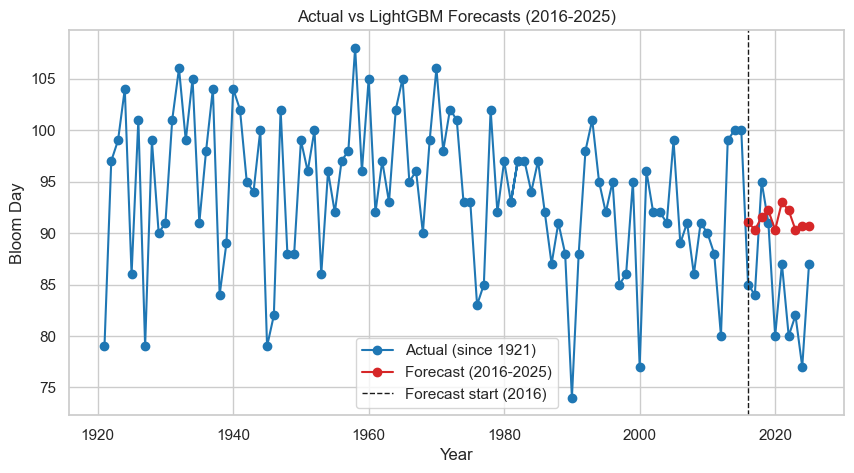

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(full_years, full_actuals.values, marker='o', color='tab:blue', label='Actual (since 1921)')

if len(test_df) > 0:
    plt.plot(test_df['year'], y_pred_test, marker='o', color='tab:red', label='Forecast (2016-2025)')
    plt.axvline(2016, color='k', linestyle='--', linewidth=1, label='Forecast start (2016)')

plt.xlabel('Year')
plt.ylabel('Bloom Day')
plt.title('Actual vs LightGBM Forecasts (2016-2025)')
plt.legend()
plt.grid(True)
plt.show()


## 10) Notes and next steps

- This LightGBM model should provide more flexible non-linear modeling than OLS. If you'd like, I can:
  - Add hyperparameter tuning (GridSearchCV or Optuna).
  - Use time-series CV folds for more robust validation.
  - Add SHAP explanations for local/global interpretability.


In [53]:
# Note: To install Optuna, run: pip install optuna
# For reproducibility, set random_state in both Optuna and LightGBM.
